# barotropic tides: FES

Link to [FES data](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/description-fes2014.html)


In [12]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

from scipy import signal

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs

import pynsitu as pin
crs = pin.maps.crs

import tides_pyTMD as td


In [13]:
pin.maps.plot_map

<function pynsitu.maps.plot_map(da=None, extent='global', projection=None, title=None, fig=None, figsize=None, ax=None, colorbar=True, colorbar_kwargs={}, centered_clims=False, gridlines=True, gridkwargs=None, bathy=None, bathy_levels=None, bathy_fill=False, land=False, coastline='110m', rivers=False, tile=None, **kwargs)>

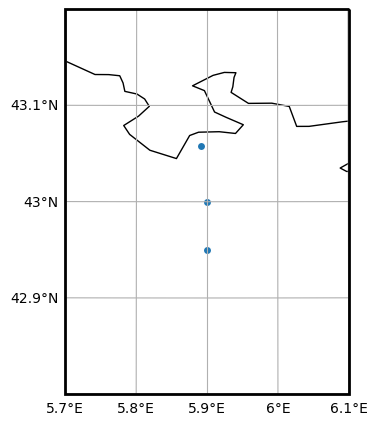

In [41]:
moorings = dict(
    shelf = [5+53.5/60, 43+3.5/60],
    shelf_break = [5+54/60, 43+0./60],
    slope = [5+54/60, 42+57/60],
)
mo = (pd.DataFrame(moorings)
      .T
      .rename(columns={0: "lon", 1: "lat"})
      .to_xarray().rename(index="mooring")
)

fig, ax, _ = pin.maps.plot_map(extent=(5.7,6.1,42.8,43.2), coastline='10m')
mo.plot.scatter(x="lon", y="lat", transform=crs)

---

## constituents, frequencies, equilibrium tides

In [34]:
td.cproperties

,amplitude,phase,omega,alpha,species,omega_cpd
m3,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
eps2,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
n4,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
mtm,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
sa,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
msqm,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
lambda2,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
msf,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
mks2,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
s4,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000


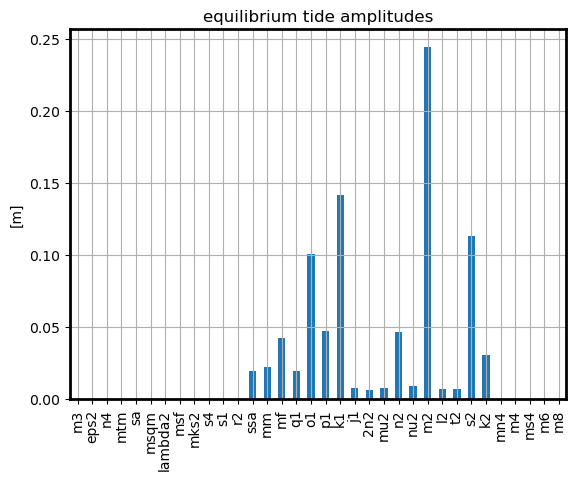

In [35]:
ax = td.cproperties.amplitude.plot.bar()
ax.set_title("equilibrium tide amplitudes")
ax.set_ylabel("[m]")
ax.grid()

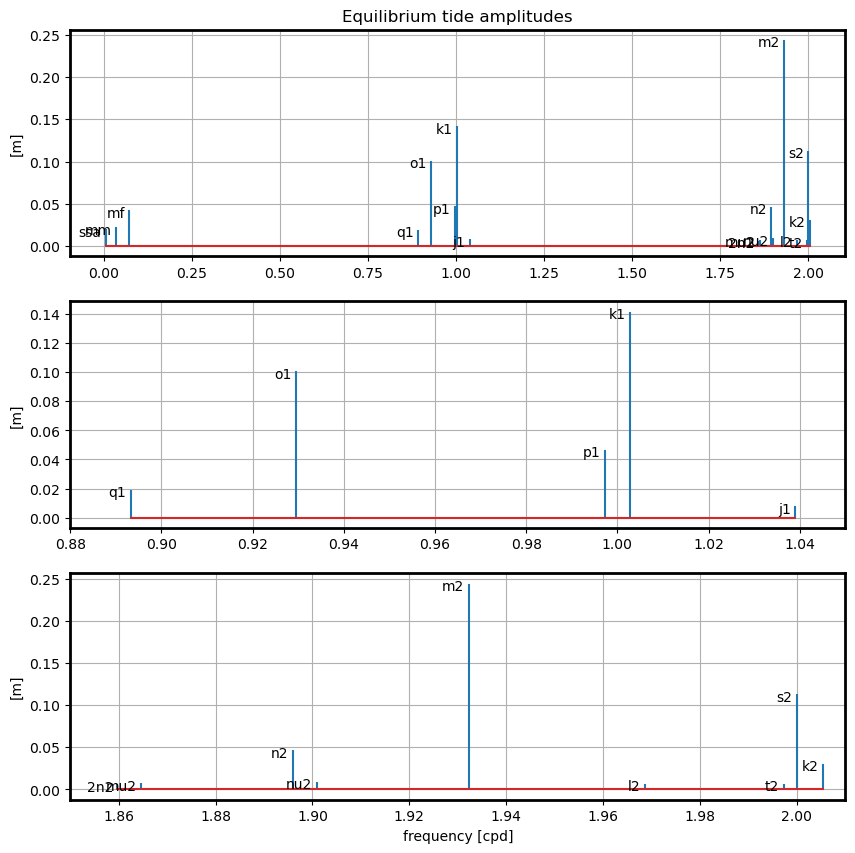

In [36]:
fig, axes = plt.subplots(3, 1, figsize=(10,10))
td.plot_equilibrium_amplitudes(td.cproperties, axes[0])
td.plot_equilibrium_amplitudes(td.cproperties, ax=axes[1], xlim=(.88, 1.05))
td.plot_equilibrium_amplitudes(td.cproperties, ax=axes[2], xlim=(1.85, 2.01))

for i in range(0,2):
    axes[i].set_xlabel("")
for i in range(1,3):
    axes[i].set_title("")

### play with tidal arguments used for predictions

$
\begin{align}
\eta = \mathcal{R} \Big \{  \sum_k h_k \times f_k(t) h_c e^{i (g_k(t) + u_k(t) ) }  \Big \}
\end{align}
$

$g_k (t)$ is the equilibrium argument, it is common to all models
$f_l(t)$ and $u_k(t)$ are nodal corrections.


Constituents have unit complex amplitudes here:

/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/load_nodal_corrections.py:109: DeprecationWarning: Deprecated. Please use pyTMD.arguments instead
  warnings.warn("Deprecated. Please use pyTMD.arguments instead",


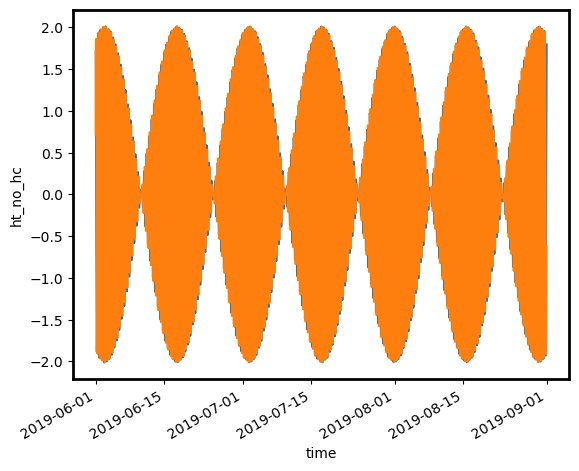

In [37]:
time = pd.date_range(start="2019/06/01", end="2019/09/01", freq="30T")

ds = td.get_tidal_arguments(time)

np.real(ds["ht_no_hc"]).sel(constituents=td.major_semidiurnal).sum("constituents").plot()
np.imag(ds["ht_no_hc"]).sel(constituents=td.major_semidiurnal).sum("constituents").plot()

---

## harmonic amplitudes

In [45]:
# constituents selected
#csts = td.default_fes_constituents
csts = td.major_semidiurnal

In [42]:
# potential resolution: 0.0625
dl_min = 0.0625
#lon, lat = (111, 126, 1/4), (-20, -10, 1/4) # large area
lon, lat = (5.7, 6.1, dl_min), (42.8, 43.2, dl_min)

broadcasting lon/lat


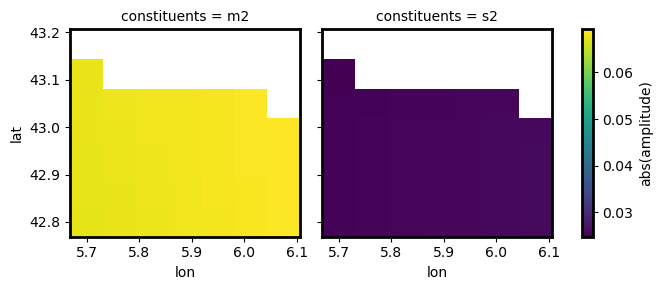

In [43]:
vtype = "z"
ds = td.load_tidal_amplitudes(lon, lat, vtype, constituents=csts)

(np.abs(ds[vtype+"_amplitude"])
 .rename("abs(amplitude)")
 .plot(x="lon", y="lat", col="constituents", col_wrap=2)
)

In [46]:
ds = td.load_tidal_amplitudes(mo.lon, mo.lat, ["z", "u", "v"], constituents=csts)

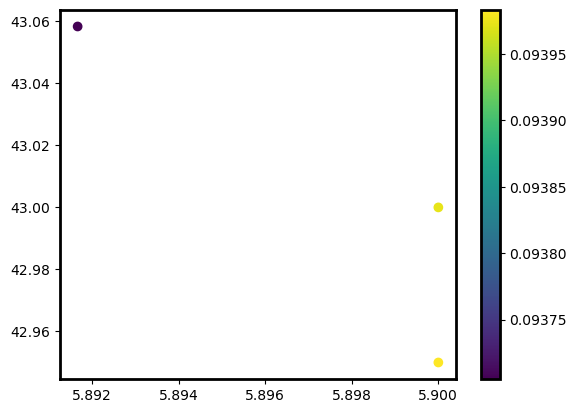

In [47]:
fig, ax = plt.subplots(1,1)
h = ax.scatter(ds.lon, ds.lat, c=np.abs(ds.z_amplitude).sum("constituents"))
fig.colorbar(h)

In [48]:
ds = td.load_raw_tidal_amplitudes(["z", "u", "v"], lon=lon, lat=lat, constituents=csts)

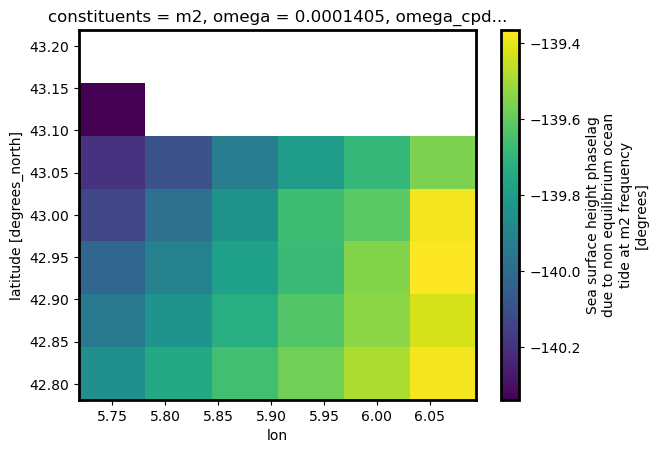

In [49]:
ds.sea_level_phase.sel(constituents="m2").plot()

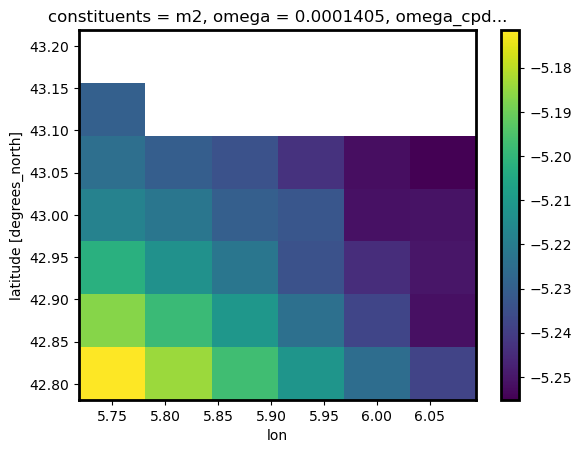

In [50]:
np.real(ds.sea_level_amplitude*np.exp(1j*ds.sea_level_phase*np.pi/180)).sel(constituents="m2").plot()

---

## predictions

In [51]:
#time = pd.date_range("2000/01/01","2000/02/01", freq="1H")

#osx["x"] = ("x", np.arange(10))
#ds = tidal_prediction( (osx.lon+osx.x*0).rename("lon"), (osx.lat+osx.x*0).rename("lat"))

#ds = td.tidal_prediction( osx.lon, osx.lat, time, ["z", "u", "v"]) # all constituents (with inference)
ds = td.tidal_prediction(mo.lon, mo.lat, time, ["z", "u", "v"], constituents=csts, minor=False)

ds

<xarray.Dataset>
Dimensions:  (mooring: 3, time: 4417)
Coordinates:
  * mooring  (mooring) object 'shelf' 'shelf_break' 'slope'
  * time     (time) datetime64[ns] 2019-06-01 2019-06-01T00:30:00 ... 2019-09-01
Data variables:
    lon      (mooring) float64 5.892 5.9 5.9
    lat      (mooring) float64 43.06 43.0 42.95
    z_tide   (mooring, time) float64 -0.08212 -0.08351 ... -0.0039 -0.02738
    u_tide   (mooring, time) float64 -0.000914 -0.0007596 ... -0.0008785
    v_tide   (mooring, time) float64 -0.0006234 -0.0003744 ... -0.0002015

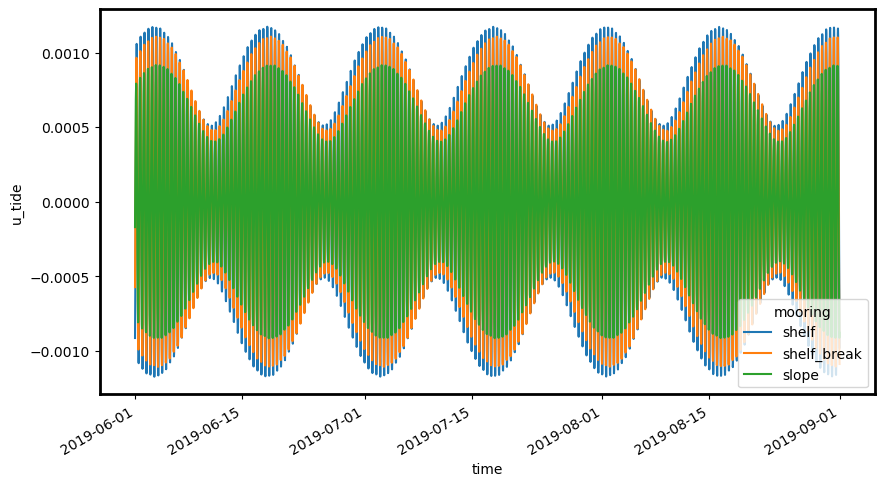

In [52]:
ax = plt.subplots(1,1, figsize=(10,5))
ds["u_tide"].plot(hue="mooring");

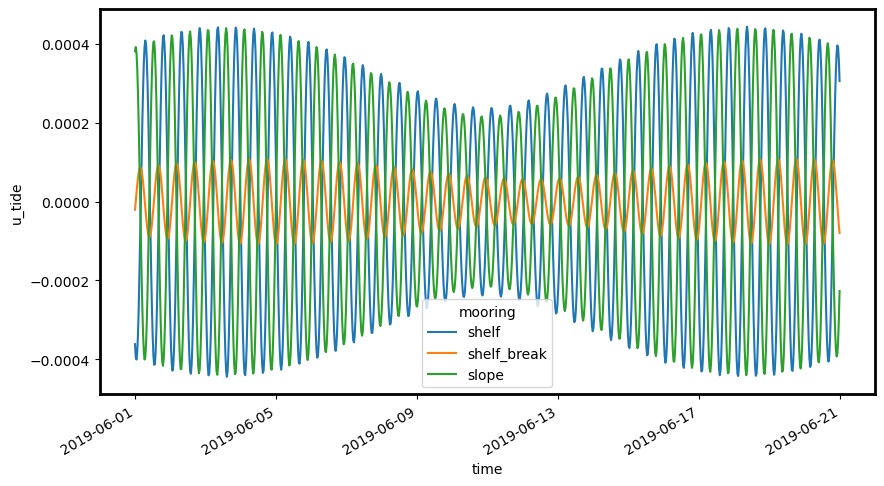

In [53]:
#ax = plt.subplots(1,1, figsize=(10,5))
#(ds["u_tide"] - ds["u_tide"].mean("mooring")).isel(time=slice(0,20*24*2)).plot(hue="mooring");

---

## store 

### all harmonics in area of interest

In [54]:
h = td.load_raw_tidal_amplitudes(["z", "u", "v"], lon=lon, lat=lat)

In [55]:
#h.to_zarr("nwa_harmonics.zarr", mode="w")
h.to_netcdf("fes2014_mooring_harmonics.nc", mode="w")

### total tidal time series at mooring locations over period of interest

In [56]:
ts = td.tidal_prediction(mo.lon, mo.lat, time, ["z", "u", "v"])

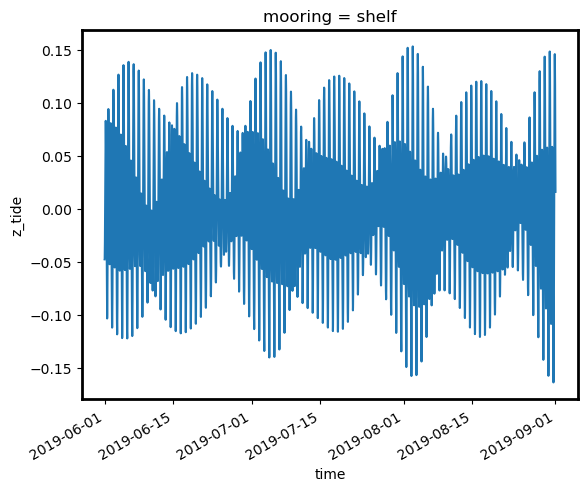

In [57]:
ts["z_tide"].isel(mooring=0).plot()

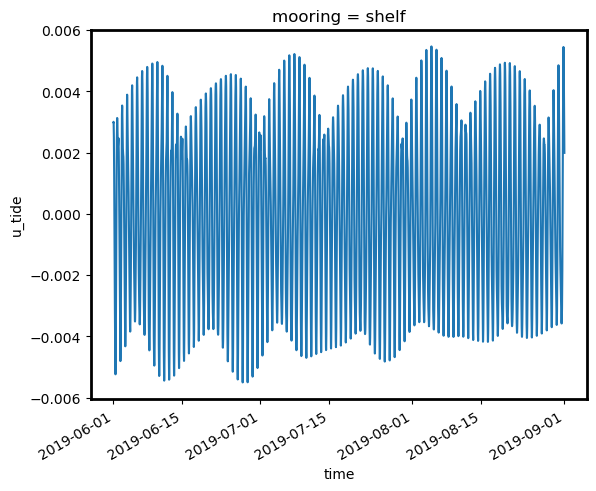

In [59]:
ts["u_tide"].isel(mooring=0).plot()

In [58]:
#ts.to_zarr("nwa_time_series.zarr", mode="w")
ts.to_netcdf("fes2014_mooring_time_series.nc", mode="w")

### semidiurnal & diurnal contributions - !! to update

In [31]:
ts = td.tidal_prediction(osx.lon, osx.lat, time, ["z", "u", "v"], constituents=td.semidiurnal, minor=False)
ts.to_zarr("osmosis_time_series_semidiurnal.zarr", mode="w")

In [32]:
ts = td.tidal_prediction(osx.lon, osx.lat, time, ["z", "u", "v"], constituents=td.diurnal, minor=False)
ts.to_zarr("osmosis_time_series_diurnal.zarr", mode="w")

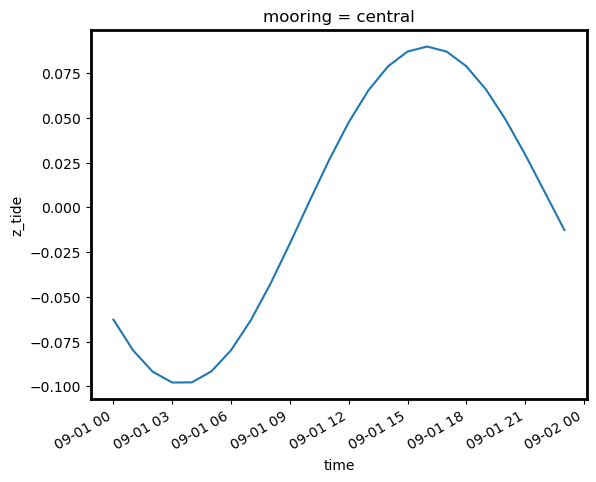

In [33]:
ts["z_tide"].isel(mooring=0, time=slice(0,24)).plot()